In [3]:
import cv2
import numpy as np
import pandas as pd
import seaborn as sns
import os
sns.set_style('darkgrid')
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

# import Deep learning Libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout, BatchNormalization
from tensorflow.keras import regularizers

# Ignore Warnings
import warnings
warnings.filterwarnings("ignore")

print ('modules loaded')

modules loaded


In [4]:
data_dir = 'C:/Users/aman6/Documents/project1/bloodcells_dataset'  # Update path for local usage
filepaths = []
labels = []

folds = os.listdir(data_dir)
for fold in folds:
    foldpath = os.path.join(data_dir, fold)
    filelist = os.listdir(foldpath)
    if fold in ['ig', 'neutrophil']:
        continue
    for file in filelist:
        fpath = os.path.join(foldpath, file)
        
        filepaths.append(fpath)
        labels.append(fold)

# Concatenate data paths with labels into one dataframe
Fseries = pd.Series(filepaths, name='filepaths')
Lseries = pd.Series(labels, name='labels')
df = pd.concat([Fseries, Lseries], axis=1)
df


,filepaths,labels
0,C:/Users/aman6/Documents/project1/bloodcells_d...,basophil
1,C:/Users/aman6/Documents/project1/bloodcells_d...,basophil
2,C:/Users/aman6/Documents/project1/bloodcells_d...,basophil
3,C:/Users/aman6/Documents/project1/bloodcells_d...,basophil
4,C:/Users/aman6/Documents/project1/bloodcells_d...,basophil
...,...,...
10863,C:/Users/aman6/Documents/project1/bloodcells_d...,platelet
10864,C:/Users/aman6/Documents/project1/bloodcells_d...,platelet
10865,C:/Users/aman6/Documents/project1/bloodcells_d...,platelet
10866,C:/Users/aman6/Documents/project1/bloodcells_d...,platelet


In [5]:
# train dataframe
train_df, dummy_df = train_test_split(df,  train_size= 0.8, shuffle= True, random_state= 123)

# valid and test dataframe
valid_df, test_df = train_test_split(dummy_df,  train_size= 0.6, shuffle= True, random_state= 123)

In [6]:
# crobed image size
batch_size = 16
img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)

tr_gen = ImageDataGenerator()
ts_gen = ImageDataGenerator()

train_gen = tr_gen.flow_from_dataframe( train_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= True, batch_size= batch_size)

valid_gen = ts_gen.flow_from_dataframe( valid_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= True, batch_size= batch_size)

test_gen = ts_gen.flow_from_dataframe( test_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= False, batch_size= batch_size)

Found 8694 validated image filenames belonging to 6 classes.
Found 1304 validated image filenames belonging to 6 classes.
Found 870 validated image filenames belonging to 6 classes.


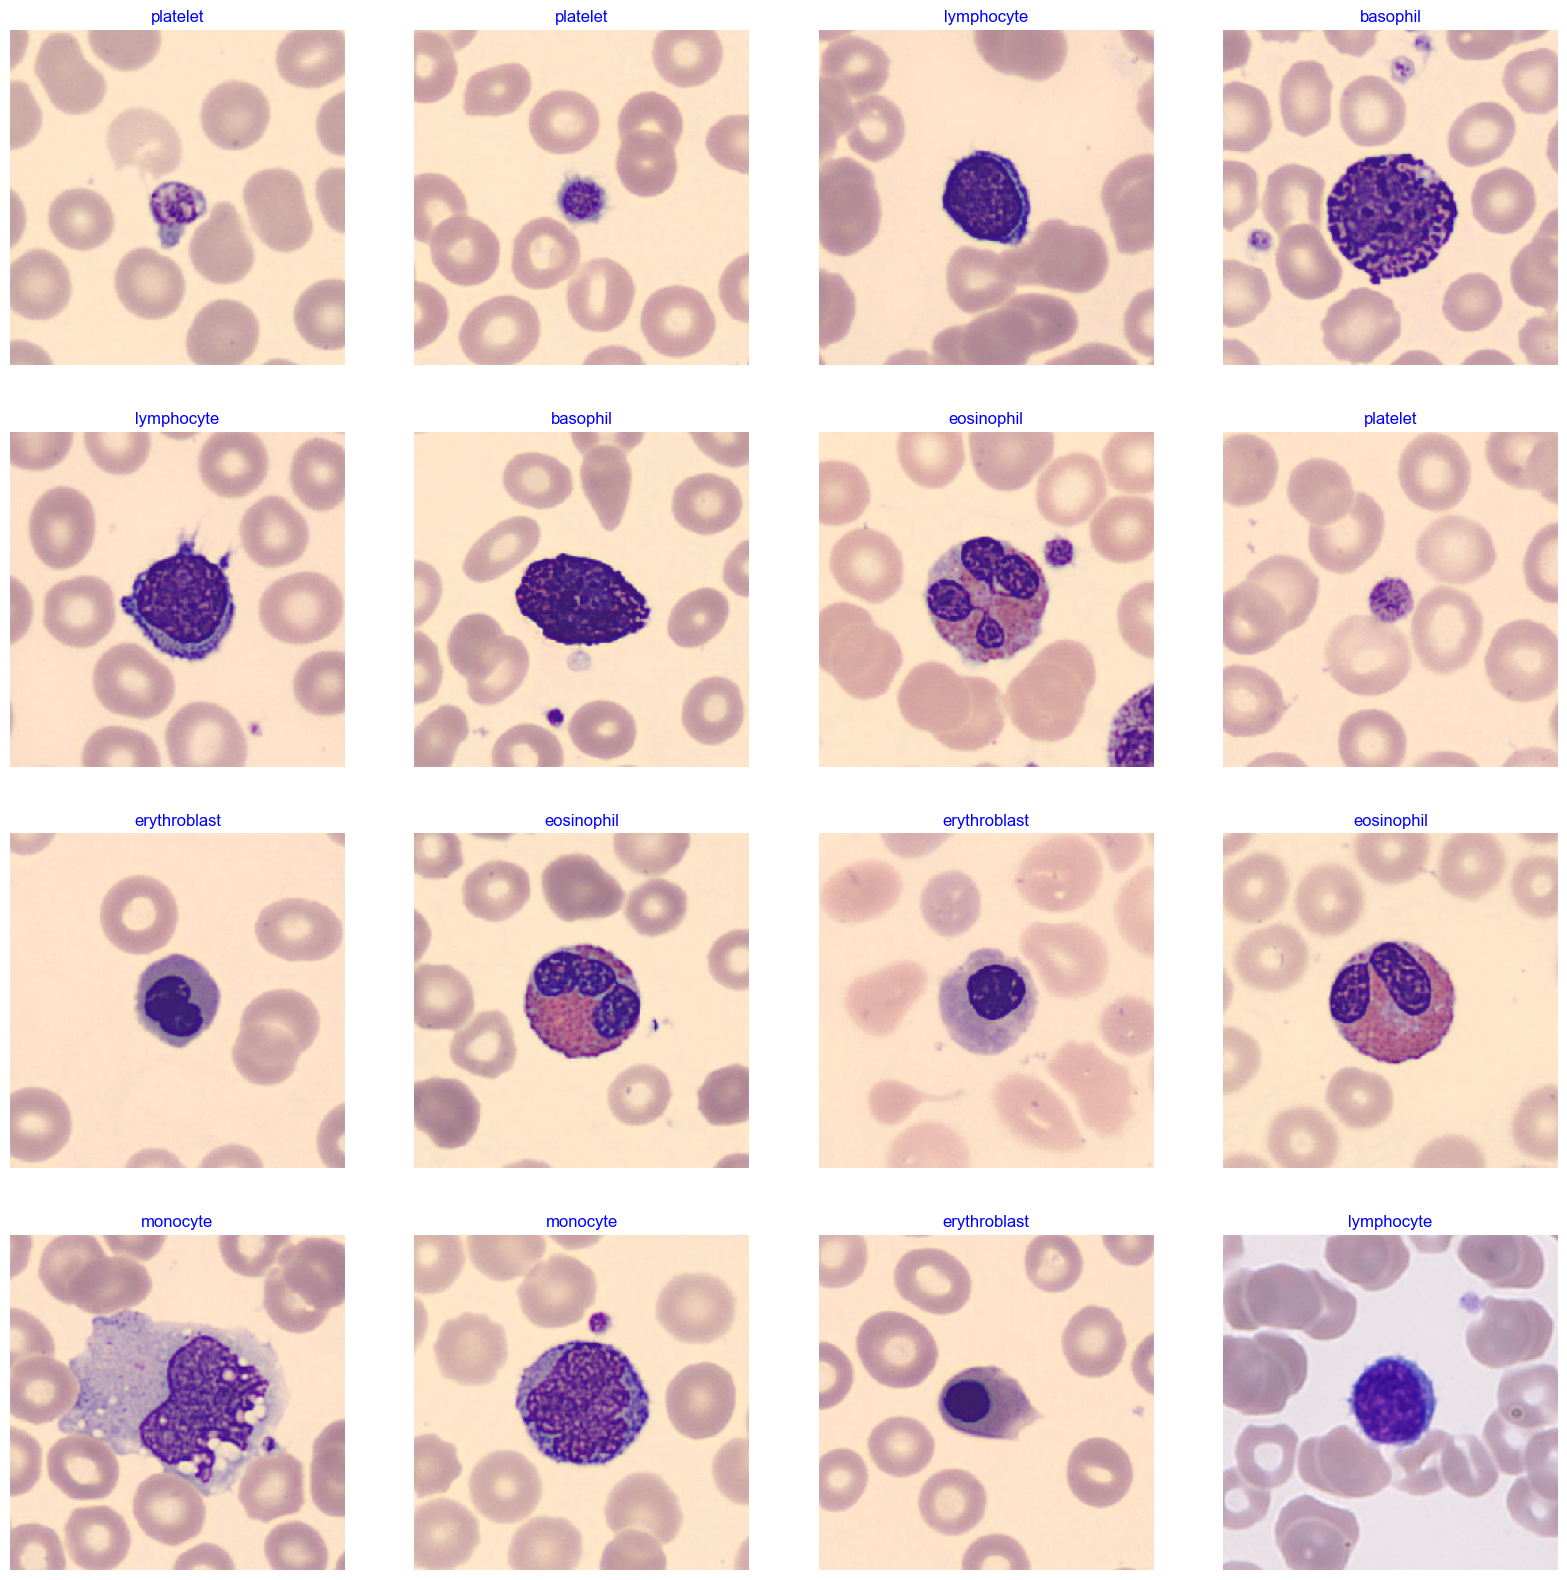

In [7]:
g_dict = train_gen.class_indices      # defines dictionary {'class': index}
classes = list(g_dict.keys())       # defines list of dictionary's kays (classes), classes names : string
images, labels = next(train_gen)      # get a batch size samples from the generator

plt.figure(figsize= (20, 20))

for i in range(16):
    plt.subplot(4, 4, i + 1)
    image = images[i] / 255       # scales data to range (0 - 255)
    plt.imshow(image)
    index = np.argmax(labels[i])  # get image index
    class_name = classes[index]   # get class of image
    plt.title(class_name, color= 'blue', fontsize= 12)
    plt.axis('off')
plt.show()

In [8]:
# import tensorflow as tf
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import BatchNormalization, Dense, Dropout
# from tensorflow.keras.optimizers import Adamax
# from tensorflow.keras import regularizers

# Create Model Structure
img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)
class_count = len(list(train_gen.class_indices.keys()))  # to define the number of classes in the dense layer

# create pre-trained model (using EfficientNetB3)
base_model = tf.keras.applications.efficientnet.EfficientNetB3(include_top=False, weights="imagenet", input_shape=img_shape, pooling='max')
# base_model.trainable = False

model = Sequential([
    base_model,
    BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001),
    Dense(256, kernel_regularizer=regularizers.l2(0.016), activity_regularizer=regularizers.l1(0.006),
                bias_regularizer=regularizers.l1(0.006), activation='relu'),
    Dropout(rate=0.45, seed=123),
    Dense(class_count, activation='softmax')
])

model.compile(Adamax(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ efficientnetb3 (Functional)          │ (None, 1536)                │      10,783,535 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 1536)                │           6,144 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │         393,472 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 6)                   │           1,542 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 11,184,693 (42.67 MB)

 Trainable params: 11,094,318 (42.32 MB)

 Non-trainable params: 90,375 (353.03 KB)

In [9]:
epochs = 10  # number of all epochs in training

history = model.fit(x= train_gen, epochs= epochs, verbose= 1, validation_data= valid_gen, 
                    validation_steps= None, shuffle= False)

Epoch 1/10
544/544 ━━━━━━━━━━━━━━━━━━━━ 1346s 2s/step - accuracy: 0.4504 - loss: 9.8892 - val_accuracy: 0.3804 - val_loss: 5.1320
Epoch 2/10
544/544 ━━━━━━━━━━━━━━━━━━━━ 1281s 2s/step - accuracy: 0.3919 - loss: 4.5272 - val_accuracy: 0.5721 - val_loss: 2.9876
Epoch 3/10
544/544 ━━━━━━━━━━━━━━━━━━━━ 1271s 2s/step - accuracy: 0.5719 - loss: 2.7293 - val_accuracy: 0.6135 - val_loss: 1.9934
Epoch 4/10
544/544 ━━━━━━━━━━━━━━━━━━━━ 1270s 2s/step - accuracy: 0.5651 - loss: 1.9180 - val_accuracy: 0.6219 - val_loss: 1.5625
Epoch 5/10
544/544 ━━━━━━━━━━━━━━━━━━━━ 1276s 2s/step - accuracy: 0.6144 - loss: 1.5316 - val_accuracy: 0.7385 - val_loss: 1.1565
Epoch 6/10
544/544 ━━━━━━━━━━━━━━━━━━━━ 1635s 3s/step - accuracy: 0.7964 - loss: 1.1831 - val_accuracy: 0.9686 - val_loss: 0.8153
Epoch 7/10
544/544 ━━━━━━━━━━━━━━━━━━━━ 2196s 4s/step - accuracy: 0.9003 - loss: 0.9640 - val_accuracy: 0.9939 - val_loss: 0.6496
Epoch 8/10
544/544 ━━━━━━━━━━━━━━━━━━━━ 2204s 4s/step - accuracy: 0.9107 - loss: 0.8456 - 

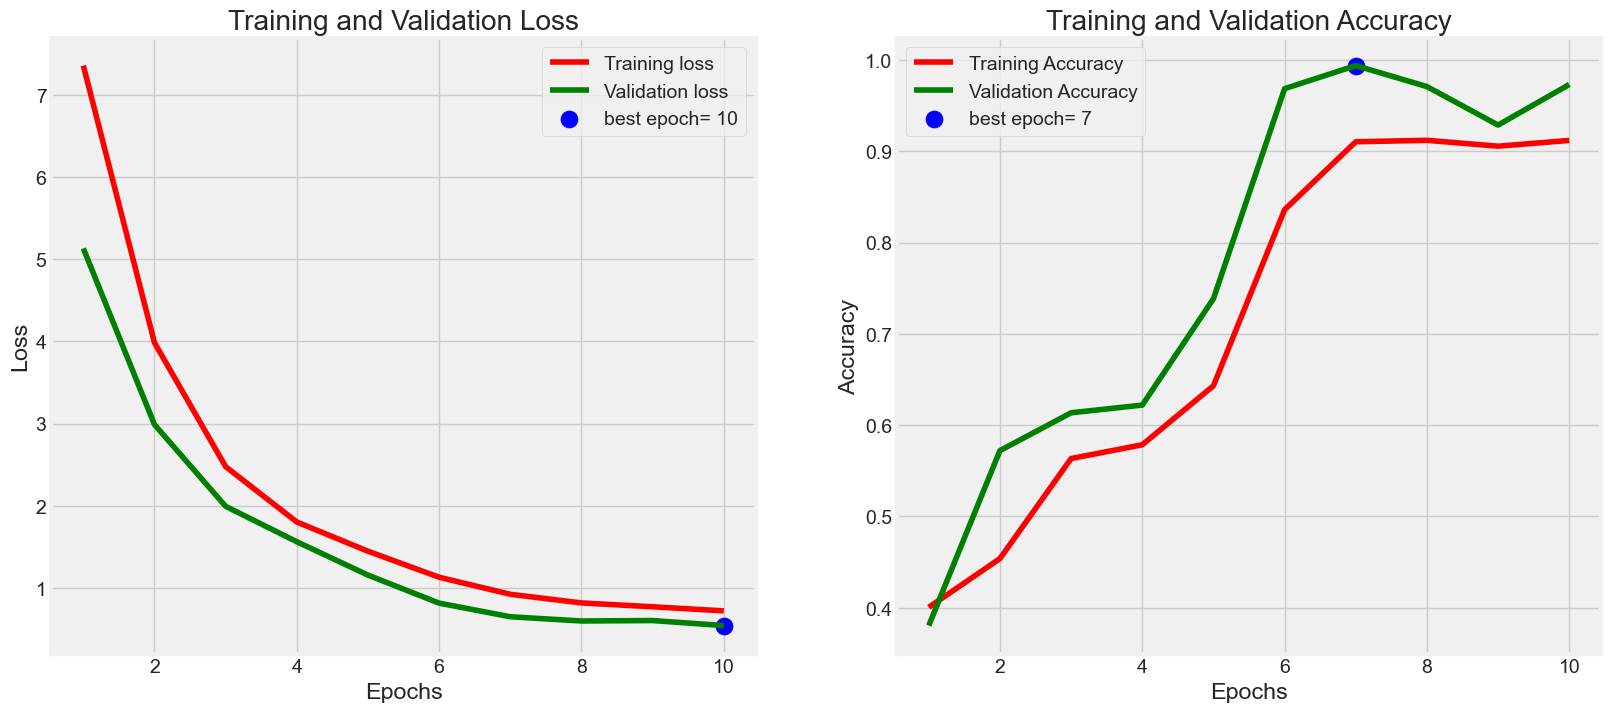

In [10]:
# Define needed variables
tr_acc = history.history['accuracy']
tr_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]
index_acc = np.argmax(val_acc)
acc_highest = val_acc[index_acc]
Epochs = [i+1 for i in range(len(tr_acc))]
loss_label = f'best epoch= {str(index_loss + 1)}'
acc_label = f'best epoch= {str(index_acc + 1)}'

# Plot training history
plt.figure(figsize= (20, 8))
plt.style.use('fivethirtyeight')

plt.subplot(1, 2, 1)
plt.plot(Epochs, tr_loss, 'r', label= 'Training loss')
plt.plot(Epochs, val_loss, 'g', label= 'Validation loss')
plt.scatter(index_loss + 1, val_lowest, s= 150, c= 'blue', label= loss_label)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(Epochs, tr_acc, 'r', label= 'Training Accuracy')
plt.plot(Epochs, val_acc, 'g', label= 'Validation Accuracy')
plt.scatter(index_acc + 1 , acc_highest, s= 150, c= 'blue', label= acc_label)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout
plt.show()

In [11]:
ts_length = len(test_df)
test_batch_size = max(sorted([ts_length // n for n in range(1, ts_length + 1) if ts_length%n == 0 and ts_length/n <= 80]))
test_steps = ts_length // test_batch_size

train_score = model.evaluate(train_gen, steps= test_steps, verbose= 1)
valid_score = model.evaluate(valid_gen, steps= test_steps, verbose= 1)
test_score = model.evaluate(test_gen, steps= test_steps, verbose= 1)

print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print('-' * 20)
print("Validation Loss: ", valid_score[0])
print("Validation Accuracy: ", valid_score[1])
print('-' * 20)
print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])

15/15 ━━━━━━━━━━━━━━━━━━━━ 6s 400ms/step - accuracy: 0.9780 - loss: 0.5164
15/15 ━━━━━━━━━━━━━━━━━━━━ 6s 394ms/step - accuracy: 0.9585 - loss: 0.5702
15/15 ━━━━━━━━━━━━━━━━━━━━ 6s 426ms/step - accuracy: 0.9883 - loss: 0.5052
Train Loss:  0.5188900828361511
Train Accuracy:  0.9791666865348816
--------------------
Validation Loss:  0.5853968262672424
Validation Accuracy:  0.9541666507720947
--------------------
Test Loss:  0.5134636163711548
Test Accuracy:  0.9791666865348816


In [12]:
preds = model.predict(test_gen)
y_pred = np.argmax(preds, axis=1)

55/55 ━━━━━━━━━━━━━━━━━━━━ 30s 477ms/step


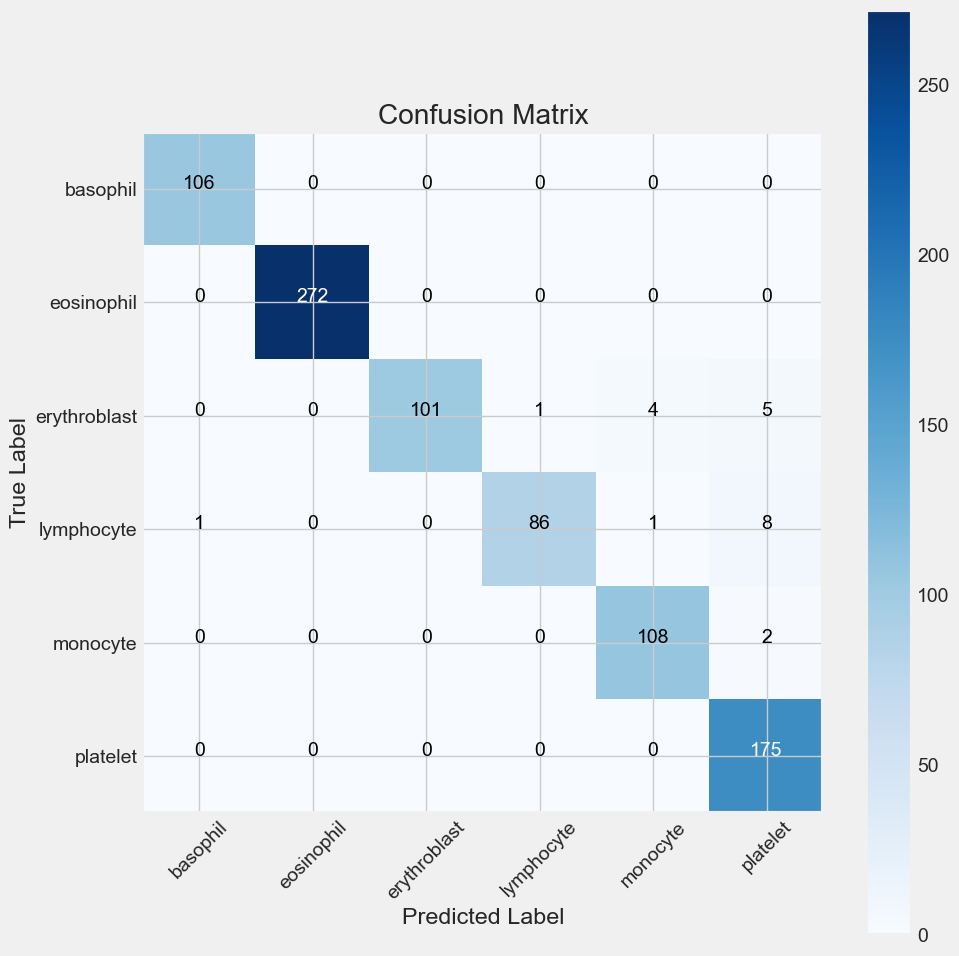

In [13]:
import itertools

g_dict = test_gen.class_indices
classes = list(g_dict.keys())

# Confusion matrix
cm = confusion_matrix(test_gen.classes, y_pred)

plt.figure(figsize= (10, 10))
plt.imshow(cm, interpolation= 'nearest', cmap= plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()

tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation= 45)
plt.yticks(tick_marks, classes)


thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j], horizontalalignment= 'center', color= 'white' if cm[i, j] > thresh else 'black')

plt.tight_layout()
plt.ylabel('True Label')
plt.xlabel('Predicted Label')

plt.show()

In [14]:
# Classification report
print(classification_report(test_gen.classes, y_pred, target_names= classes))

              precision    recall  f1-score   support

    basophil       0.99      1.00      1.00       106
  eosinophil       1.00      1.00      1.00       272
erythroblast       1.00      0.91      0.95       111
  lymphocyte       0.99      0.90      0.94        96
    monocyte       0.96      0.98      0.97       110
    platelet       0.92      1.00      0.96       175

    accuracy                           0.97       870
   macro avg       0.98      0.96      0.97       870
weighted avg       0.98      0.97      0.97       870



In [15]:
# Save the model in the new Keras format
model.save('Bloods.keras')


In [16]:
loaded_model = tf.keras.models.load_model('Bloods.keras', compile=False)
loaded_model.compile(Adamax(learning_rate= 0.001), loss= 'categorical_crossentropy', metrics= ['accuracy'])

In [36]:
from PIL import Image


image_path = r'C:\Users\aman6\Documents\project1\bloodcells_dataset\lymphocyte\LY_32985.jpg'
image = Image.open(image_path)
image = image.convert('RGB')

# Preprocess the image
img = image.resize((224, 224))
img_array = img_array / 255.0  # Normalize pixel values if required
img_array = tf.keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)
# Make predictions
predictions = loaded_model.predict(img_array)
class_labels = ['Basophil', 'Eosinophil', 'Erythroblast', 'IG', 'lymphocyte', 'Monocyte', 'Neutrophil', 'Platelet']
score = tf.nn.softmax(predictions[0])
print(f"{class_labels[tf.argmax(score)]}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step
Monocyte
